# ODS - 1 HomeWork - Anthony Palmieri 2038503

In this homework we focused on a semi-supervised
learning problem. Specifically, given a dataset composed
of labeled observations, we discarded all but 3% of the total
amount of labels and then tried to infer these discarded labels via optimization algorithms.
In our case we analyzed two datasets:
1. a dataset randomly generated via Sklearn library;
2. the Census dataset, which can be found [here](https://archive.ics.uci.edu/ml/datasets/Adult).

The optimization algorithms we tested are respectively:
* Gradient Descent;
* Gradient Descent with Nesterov Momentum;
* Cyclic Block Coordinate Gradient Descent;
* Uniform Randomized Block Coordinate Gradient Descent;
* Nesterov Randomized Block Coordinate Gradient Descent;
* Gauss-Southwell Block Coordinate Gradient Descent.

The notebook is structured into three sections:
1. Definition of the algorithms we're going to use;
2. Application of said algorithms on the dataset randomly generated;
3. Application of said algorithms on the Census dataset.

Moreover, sections 2 and 3 are furtherly split into 4 subsections:
* Initialization of the dataset;
* Weight Matrices and Lipschitz constants;
* Algorithms application with random starting point;
* Algorithms application with kNN-generated starting point.

Let's start by importing all the needed libraries.

In [ ]:
# let's import the libraries we'll need
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import numpy.linalg as la
from collections import Counter
from scipy.stats import mode
import pandas as pd
from pandas.api.types import is_string_dtype
import time

# Implemenetation of various optimization algorithms

In the following we define the various optimization methods we're going to test. Let's start by defining a function to compute the partial derivatives of the Loss, and a function to compute the accuracy at each iteration.

In [ ]:
# the following function computes the j-th partial derivative of f, i.e. the partial derivative of f w.r.t. y_j
# here S[j] = sum(W[:, j]) where W[:, j] is the j-th column of W. Same thing holds for S_bar

def grad_j_f(y, j, S, S_bar, W, W_bar):
  return 2*(y[j]*(S[j]+S_bar[j]) - np.dot(y_bar.T, W[:,j]) - np.dot(W_bar[j,:], y))

# we also implement the function accuracy_score, which we'll use to compute accuracy at each iteration
# Given a new_iterate we predict the labels based on the sign of the components of new_iterate
# Specifically, for each component j such that new_iterate[j]>=0, we predict 1, 
# whereas for each component j such that new_iterate[j]<0, we predict -1 

def accuracy_score(new_iterate, true_labels):
  y_pred = np.ones(new_iterate.shape[0]) # we initialize a vecores of 1's, the vector of predicted values
  y_pred[new_iterate < 0] = -1 # for each component j such that new_iterate[j]<0, we predict -1
  accuracy = np.sum((true_labels - y_pred) == 0)/new_iterate.shape[0] # fraction of correctly predicted values
  return accuracy

## Gradient Descent 

In [ ]:
def gradient_descent(y0, y_true, step_size, S, S_bar, W, W_bar, toll=1e-8, max_iter=10000):
  
  start = time.time() # starting time for the method
  k = 0 # we use k to account for the number of iterations
  times = [] # we'll use this to plot accuracy vs CPU time
  accuracy = [] # here we'll store the accuracy scores achieved at each iteration
  y_old = y0
  y_new = np.zeros(y0.shape[0]) # y_new will store the new iterate ad each iteration
  grad_f = np.ones(y0.shape[0]) # we'll use this to construct the gradient at each iteration
  sum = 1 # sum will store the squared norm of gradient at each iteration. We initialize it to 1 just to enter the while loop  

  while np.sqrt(sum)>toll and k<max_iter:
    k+=1
    sum = 0
    for j in range(y_new.shape[0]): # in this for loop we build the gradient and the new iterate
      grad_f[j] = grad_j_f(y_old, j, S, S_bar, W, W_bar) # partial derivative of f w.r.t. y_j computed in the previous iterate y_old
      sum += np.power(grad_f[j],2) # we store the squared value in sum to compute the squared norm of the gradient
      y_new[j] = y_old[j] - step_size*grad_f[j] # we build the new iterate one component at the time
    y_old = y_new

    # computation of accuracy score
    accuracy.append(accuracy_score(y_new, y_true))

    # we store the time elapsed so far
    times.append(time.time()-start)
    
  
  return (y_old, grad_f, k, accuracy, times)

## Gradient Descent with Nesterov Momentum

In [ ]:
def gradient_descent_nesterov(y0, y_true, step_size, S, S_bar, W, W_bar, toll=1e-8, max_iter=10000):
  
  start = time.time() # starting time for the method
  k = 0 # we use k to account for the number of iterations
  times = [] # we'll use this to plot accuracy vs CPU time
  accuracy = [] # here we'll store the accuracy scores achieved at each iteration
  y_old = y0
  lambda_old = 1 # lambda_old, lambda_new will be used to compute beta_k stepsize for extrapolation step at iteration k
  y_new = np.zeros(y0.shape[0]) # y_new will store the new iterate ad each iteration
  grad_f = np.ones(y0.shape[0]) # we'll use this to construct the gradient at each iteration
  sum = 0 #sum will store the squared norm of gradient at each iteration.

  # first iteration is classical gradient descent 
  for j in range(y_new.shape[0]):
      grad_f[j] = grad_j_f(y_old, j, S, S_bar, W, W_bar) # partial derivative of f w.r.t. y_j computed in the previous iterate y_old
      sum += np.power(grad_f[j],2) # we store the squared value in sum to compute the squared norm of the gradient
      y_new[j] = y_old[j] - step_size*grad_f[j] # we build the new iterate one component at the time
  y_older = y_old
  y_old = y_new
  
  # computation of accuracy score
  accuracy.append(accuracy_score(y_new, y_true))

  # we store the time elapsed so far
  times.append(time.time()-start)
  
  # we update the number of iteration carried out
  k += 1

  # having two iterates we can then start with accellerated GD with nesterov momentum
  while np.sqrt(sum)>toll and k<max_iter:
    k+=1
    sum = 0
    lambda_new = (1+np.sqrt(1+4*lambda_old**2))/4.0
    beta = (lambda_old-1)/lambda_new # stepsize for extrapolation step
    x = y_old + beta*(y_old-y_older) # we move along the direction of the difference between the last two iterates up until point x
    
    # we then apply GD in the new point x to build the new iterate y_new
    for j in range(y_new.shape[0]):
      grad_f[j] = grad_j_f(x, j, S, S_bar, W, W_bar) # partial derivative of f w.r.t. y_j computed in the point x
      sum += np.power(grad_f[j],2) # we store the squared value in sum to compute the squared norm of the gradient
      y_new[j] = x[j] - step_size*grad_f[j] # we build the new iterate one component at the time
    lambda_old = lambda_new # we update the lambda values to compute the extrapolation stepsize at next iteration
    y_older = y_old
    y_old = y_new
    
    # computation of accuracy score
    accuracy.append(accuracy_score(y_new, y_true))

    # we store the time elapsed so far
    times.append(time.time()-start)   

  return (y_new, grad_f, k, accuracy, times)

## Cyclic BCGD

In [ ]:
def BCGD_cyclic(y0, y_true, step_size, S, S_bar, W, W_bar, toll=1e-8, max_iter=10000):
  
  start = time.time() # starting time for the method
  k = 0 # we use k to account for the number of iterations
  times = [] # we'll use this to plot accuracy vs CPU time
  accuracy = [] # here we'll store the accuracy scores achieved at each iteration
  y_old = y0
  y_new = np.zeros(y0.shape[0]) # y_new will store the new iterate ad each iteration
  sum = 1 # sum will store the squared norm of gradient at each iteration. We initialize it to 1 just to enter the while loop

  while np.sqrt(sum)>toll and k<max_iter:
    k+=1
    x_old = y_old
    x_new = np.zeros(y0.shape[0]) # we'll use this to construct the intermediate iterates, cycling through the blocks
    for j in range(y_new.shape[0]): # in this for loop we build the new iterate, cycling through the blocks and applying GD
      grad_f = np.zeros(y0.shape[0]) 
      grad_f[j] = grad_j_f(x_old, j, S, S_bar, W, W_bar) # partial derivative of f w.r.t. y_j computed in the intermediate iterate x_old
      x_new = x_old - step_size[j]*grad_f # we build the new intermediate iterate and start all over again with the next block
      x_old = x_new
    y_new = x_new # once all the block are done, we have the new BCGD iterate y_new
    y_old = y_new

    # computation of accuracy score
    accuracy.append(accuracy_score(y_new, y_true)) 

    # we store the time elapsed so far
    times.append(time.time()-start)   

    sum=0 # we use sum to store the squared norm of the gradient at each iteration
    for j in range(y0.shape[0]):
      grad_f[j] = grad_j_f(y_new, j, S, S_bar, W, W_bar) # partial derivative of f w.r.t. y_j computed in the last iterate y_new 
      sum += np.power(grad_f[j],2)  

  return (y_new, grad_f, k, accuracy, times)

## Randomized BCGD with uniform distribution

In [ ]:
def BCGD_randomized_uniform_distribution(y0, y_true, step_size, S, S_bar, W, W_bar, toll=1e-8, max_iter=10000):
  
  start = time.time() # starting time for the method
  k = 0 # we use k to account for the number of iterations
  times = [] # we'll use this to plot accuracy vs CPU time
  accuracy = [] # here we'll store the accuracy scores achieved at each iteration
  y_old = y0
  y_new = np.zeros(y0.shape[0]) # y_new will store the new iterate ad each iteration
  sum = 1 # sum will store the squared norm of gradient at each iteration. We initialize it to 1 just to enter the while loop
  
  while np.sqrt(sum)>toll and k<max_iter:
    k+=1
    block = np.random.randint(0, y0.shape[0]) # we pick uniformly at random the block we'll use to update the gradient
    grad_f = np.zeros(y0.shape[0]) # we'll use this to construct the gradient at each iteration
    grad_f[block] = grad_j_f(y_old, block, S, S_bar, W, W_bar) # partial derivative of f w.r.t. y_block computed in the previous iterate y_old
    y_new = y_old - step_size[block]*grad_f
    y_old = y_new
    
    # computation of accuracy score
    accuracy.append(accuracy_score(y_new, y_true))

    # we store the time elapsed so far
    times.append(time.time()-start)   

    sum=0 # we use sum to store the squared norm of the gradient at each iteration
    for j in range(y0.shape[0]):
      grad_f[j] = grad_j_f(y_new, j, S, S_bar, W, W_bar) # partial derivative of f w.r.t. y_j computed in the last iterate y_new 
      sum += np.power(grad_f[j],2)
  
  return (y_new, grad_f, k, accuracy, times)

## Randomized BCGD with Nesterov distribution

In [ ]:
def BCGD_randomized_nesterov_distribution(y0, y_true, step_size, S, S_bar, W, W_bar, toll=1e-8, max_iter=10000):
  
  start = time.time() # starting time for the method
  k = 0 # we use k to account for the number of iterations
  times = [] # we'll use this to plot accuracy vs CPU time
  accuracy = [] # here we'll store the accuracy scores achieved at each iteration
  y_old = y0
  y_new = np.zeros(y0.shape[0]) # y_new will store the new iterate ad each iteration
  sum = 1 # sum will store the squared norm of gradient at each iteration. We initialize it to 1 just to enter the while loop
  
  while np.sqrt(sum)>toll and k<max_iter:
    k+=1
    block = np.random.choice(np.arange(y0.shape[0]), size=1, replace=True, p=L_k/np.sum(L_k)) # we pick a block at random using Nesterov distribution. We'll use it to update the gradient
    grad_f = np.zeros(y0.shape[0]) # we'll use this to construct the gradient at each iteration
    grad_f[block] = grad_j_f(y_old, block, S, S_bar, W, W_bar) # partial derivative of f w.r.t. y_block computed in the previous iterate y_old
    y_new = y_old - step_size[block]*grad_f
    y_old = y_new
    
    # computation of accuracy score
    accuracy.append(accuracy_score(y_new, y_true))  

    # we store the time elapsed so far
    times.append(time.time()-start)  

    sum=0
    for j in range(y0.shape[0]):
      grad_f[j] = grad_j_f(y_new, j, S, S_bar, W, W_bar)
      sum += np.power(grad_f[j],2)
  
  return (y_new, grad_f, k, accuracy, times)

## BCGD with Gauss-Southwell rule

In [ ]:
def BCGD_GS(y0, y_true, step_size, S, S_bar, W, W_bar, toll=1e-8, max_iter=10000):
  
  start = time.time() # starting time for the method
  k = 0 # we use k to account for the number of iterations
  times = [] # we'll use this to plot accuracy vs CPU time
  accuracy = [] # here we'll store the accuracy scores achieved at each iteration
  y_old = y0
  y_new = np.zeros(y0.shape[0]) # y_new will store the new iterate ad each iteration
  sum = 1 # sum will store the squared norm of gradient at each iteration. We initialize it to 1 just to enter the while loop

  while np.sqrt(sum)>toll and k<max_iter:
    k+=1
    grad_f = np.zeros(y0.shape[0]) # we'll use this to store the norms of gradient on each block
    for j in range(y0.shape[0]):
      grad_f[j] = np.abs(grad_j_f(y_old, j, S, S_bar, W, W_bar)) # absolute value of partial derivative of f w.r.t. y_j computed in the previous iterate y_old
      # being the blocks 1-dim, grad_f[j] is exactly the norm of the gradient of f w.r.t. the j-th block
    block = np.argmax(grad_f) # we select the block which attains the maximum norm of the gradient
    grad_f = np.zeros(y0.shape[0]) # we'll use this to construct the gradient needed to the update the iterate
    grad_f[block] = grad_j_f(y_old, block, S, S_bar, W, W_bar) # partial derivative of f w.r.t. y_block computed in the previous iterate y_old
    y_new = y_old - step_size[block]*grad_f
    y_old = y_new
    
    # computation of accuracy score
    accuracy.append(accuracy_score(y_new, y_true))

    # we store the time elapsed so far
    times.append(time.time()-start)    

    sum=0
    for j in range(y0.shape[0]):
      grad_f[j] = grad_j_f(y_new, j, S, S_bar, W, W_bar)
      sum += np.power(grad_f[j],2)
  
  return (y_new, grad_f, k, accuracy, times)

# Fake Dataset generated via Sklearn

## Initialization

In [ ]:
# generate two random clusters in R^2, where each point is labeled as 0 or 1
m = 10000 # total amount of points to generate

# X is a matrix m by 2 which stores the features of each point, y is a vector m by 1 which stores the true label of each point
X, y = make_blobs(n_samples=m, centers=2, n_features=2, center_box=(- 10.0, 10.0), shuffle=True, random_state=42)

# let's change the label 0 to -1
y[y==0]=-1
print(f'labels: {np.unique(y)}')

# let's discard all but 3% of labels out of the entire dataset. We'll do this by generating a set of random indexes for which we'll keep the labels
np.random.seed(42)
# indexes for which to keep the labels
labeled = np.sort(np.unique(np.random.randint(0, high=y.shape[0], size=int(y.shape[0]*3/100), dtype=int)))
#print(labeled)

# indexes for which we'll discard the labels
unlabeled = np.sort(np.array(list(set(range(y.shape[0]))-set(labeled))))
#print(unlabeled)
# save the discarded labels in y_true to compute accuracy later on
y_true = y[unlabeled]

# discard labels
y[unlabeled]=0

print(f'# unlabeled examples: {sum(y==0)}\n# labeled examples: {sum((y==-1)+(y==1))}')

labels: [-1  1]
# unlabeled examples: 9705
# labeled examples: 295


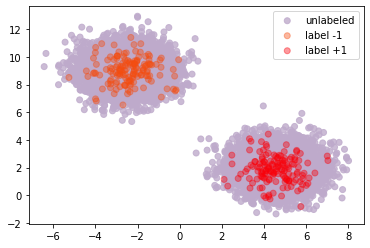

In [ ]:
#let's plot the points just to have a clue about what's going on
colors = np.zeros((y.shape[0],3)) # for each point we need to store 3 RGB values
colors[y==0] = 190,170,203 # color of unlabeled examples
colors[y==-1] = 245,77,16 # color of examples of class -1
colors[y==1] = 250,1,10 # color of examples of class 1

#plt.scatter(X[:,0],X[:,1], c=colors/255.0, alpha=0.6)

plt.scatter(X[y==0,0],X[y==0,1], c=colors[y==0]/255.0, alpha=0.8, label='unlabeled')
plt.scatter(X[y==-1,0],X[y==-1,1], c=colors[y==-1]/255.0, alpha=0.4, label='label -1')
plt.scatter(X[y==1,0],X[y==1,1], c=colors[y==1]/255.0, alpha=0.4, label='label +1')
plt.legend()
plt.show()

## Weight Matrices and Lipschitz constants

Let's compute the weight matrixes (~20 minutes)

In [ ]:
# similarity measure between labeled-unlabeled
def similarity_LabUnlab(x1,x2, sigma = 1):
  return np.exp(-0.5*la.norm(x1-x2)/np.power(sigma,2))

# similarity measure between unlabeled-unlabeled
def similarity_UnlabUnlab(x1,x2, sigma = 1):
  return np.exp(-0.5*la.norm(x1-x2)/np.power(sigma,2))

# we initialize the weight matrices setting all entries to zero
W = np.zeros((labeled.shape[0], unlabeled.shape[0]))
W_bar = np.zeros((unlabeled.shape[0], unlabeled.shape[0]))

# we then fill every entry with the similarity measures defined above
for i in range(W.shape[0]):
  for j in range(W.shape[1]):    
    W[i,j] = similarity_LabUnlab(X[labeled[i],:],X[unlabeled[j],:])

for i in range(W_bar.shape[0]):
  for j in range(W_bar.shape[1]):    
    W_bar[i,j] = similarity_UnlabUnlab(X[unlabeled[i],:],X[unlabeled[j],:])

# let's check if W_bar is symmetric
print(f'W_bar is symmetric: {(W_bar==W_bar.T).all()}')

W_bar is symmetric: True


let's then compute the Lipschitz constants for the various gradients (~10 minutes).

In [ ]:
S = np.sum(W, axis=0) # vector whose component S[j] is the sum of values of the j-th column of W
S_bar = np.sum(W_bar, axis=0) # vector whose component S_bar[j] is the sum of values of the j-th column of W_bar
y_bar = y[labeled]

# Lipschitz constants and optimal fixed stepsizes for GD's
L = 2*la.norm(np.diag(S+S_bar)-W_bar, 2) # Lipschitz constant for the gradient of f
GD_stepsize = 1.0/L # optimal fixed stepsize for Gradient Descent methods
L_k = 2*(S+S_bar-np.diag(W_bar)) # block-wise Lipschitz constants for the gradient of f
BCGD_stepsizes = 1.0/L_k # optimal fixed stepsizes for Block Coordinate Gradient Descent methods

let's define the starting points for our iterative algorithms

In [ ]:
# random starting point, where each component is picked at random uniformly in [-1, 1]
np.random.seed(423)
y0 = 2*np.random.rand(unlabeled.shape[0])-1

# starting point based on k-nearest neighbor
def k_neighbors(P, dataset, k):
  neighs = {} # we use this dictionary to save indexes of neighbors and their respective distances from point P
  for i in range(dataset.shape[0]):
    neighs[i] = la.norm(P - dataset[i,:])
  lst = list(neighs.items()) # list of tuples (index, distance) to track the neighbors of point P
  lst.sort(key=lambda x: x[1], reverse=False) # we sort the list by distance in ascending order
  return lst[:k] # we return (index, distance) for the k-nearest neighbors

# for each unlabeled point let's calculate its k-nearest neighbors among the labeled points
y0_kNN = np.zeros(unlabeled.shape[0])
k = 4
neighbors = {} # for each unlabeled point we store the index of the k-nearest neighbors among the labeled points
for i in range(unlabeled.shape[0]):
  neighbors[i] =[tpl[0] for tpl in k_neighbors(X[unlabeled[i]], X[labeled], k)]
  classes = [] # we want to assign the point the most frequent label among the k-nearest neighbors
  for index in neighbors[i]:    
    classes.append(y[labeled[index]]) # for each k-nearest neighbor we look at the label
  y0_kNN[i] = mode(classes)[0][0] # we assign the point the most frequent label among its k-nearest neighbors

print(y0_kNN)

[ 1.  1. -1. ... -1.  1.  1.]


## Algorithms application

### Randomly generated Starting Point

gradient norm: 9.698961293895623e-09
number of iterations carried out: 559
achieved accuracy score: 1.0


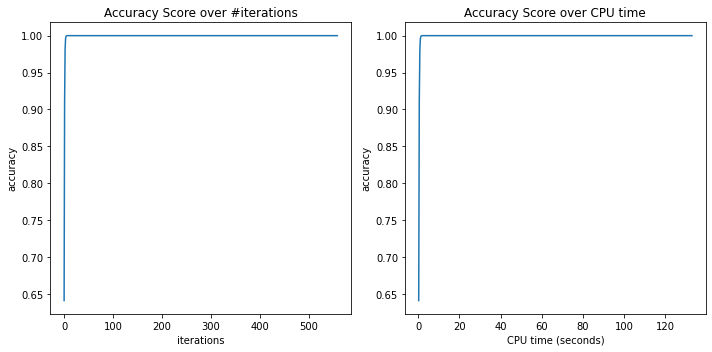

In [ ]:
results_GD = gradient_descent(y0, y_true, GD_stepsize, S, S_bar, W, W_bar)
print(f'gradient norm: {la.norm(results_GD[1])}\nnumber of iterations carried out: {results_GD[2]}\nachieved accuracy score: {results_GD[3][-1]}')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# let's plot #(iterations) vs accuracy 
axes[0].plot(range(results_GD[2]), results_GD[3])

# Add title and axis names
axes[0].set_title('Accuracy Score over #iterations')
axes[0].set_xlabel('iterations')
axes[0].set_ylabel('accuracy')


# let's also plot CPU time vs accuracy 
axes[1].plot(results_GD[4], results_GD[3])

# Add title and axis names
axes[1].set_title('Accuracy Score over CPU time')
axes[1].set_xlabel('CPU time (seconds)')
axes[1].set_ylabel('accuracy')

fig.tight_layout()
plt.show()

gradient norm: 9.846986778054223e-09
number of iterations carried out: 903
achieved accuracy score: 1.0


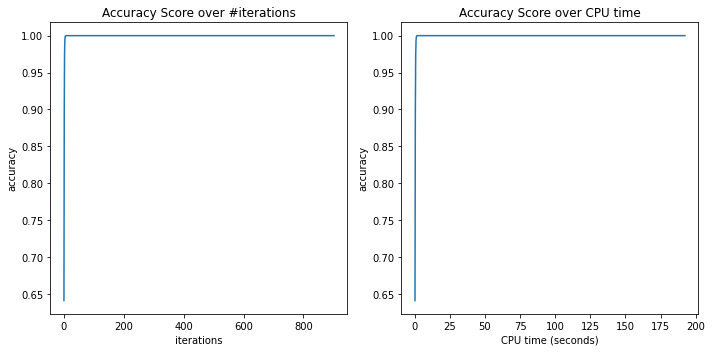

In [ ]:
results_AGD = gradient_descent_nesterov(y0, y_true, GD_stepsize, S, S_bar, W, W_bar)
print(f'gradient norm: {la.norm(results_AGD[1])}\nnumber of iterations carried out: {results_AGD[2]}\nachieved accuracy score: {results_AGD[3][-1]}')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# let's plot #(iterations) vs accuracy 
axes[0].plot(range(results_AGD[2]), results_AGD[3])

# Add title and axis names
axes[0].set_title('Accuracy Score over #iterations')
axes[0].set_xlabel('iterations')
axes[0].set_ylabel('accuracy')


# let's also plot CPU time vs accuracy 
axes[1].plot(results_AGD[4], results_AGD[3])

# Add title and axis names
axes[1].set_title('Accuracy Score over CPU time')
axes[1].set_xlabel('CPU time (seconds)')
axes[1].set_ylabel('accuracy')

fig.tight_layout()
plt.show()

gradient norm: 9.695780849345662e-09
number of iterations carried out: 366
achieved accuracy score: 1.0


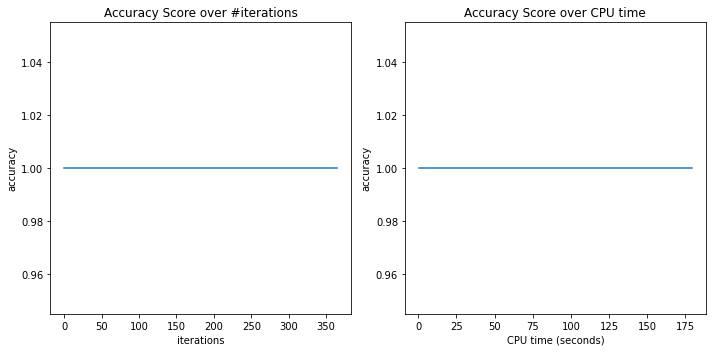

In [ ]:
results_BCGD_cyclic = BCGD_cyclic(y0, y_true, BCGD_stepsizes, S, S_bar, W, W_bar)
print(f'gradient norm: {la.norm(results_BCGD_cyclic[1])}\nnumber of iterations carried out: {results_BCGD_cyclic[2]}\nachieved accuracy score: {results_BCGD_cyclic[3][-1]}')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# let's plot #(iterations) vs accuracy 
axes[0].plot(range(results_BCGD_cyclic[2]), results_BCGD_cyclic[3])

# Add title and axis names
axes[0].set_title('Accuracy Score over #iterations')
axes[0].set_xlabel('iterations')
axes[0].set_ylabel('accuracy')


# let's also plot CPU time vs accuracy 
axes[1].plot(results_BCGD_cyclic[4], results_BCGD_cyclic[3])

# Add title and axis names
axes[1].set_title('Accuracy Score over CPU time')
axes[1].set_xlabel('CPU time (seconds)')
axes[1].set_ylabel('accuracy')

fig.tight_layout()
plt.show()

gradient norm: 98443.45902738166
number of iterations carried out: 20000
achieved accuracy score: 0.9375579598145286


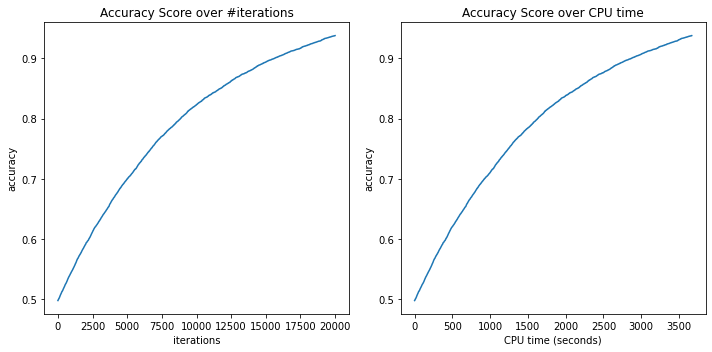

In [ ]:
#~1h, 10m
results_BCGD_rand_unif = BCGD_randomized_uniform_distribution(y0, y_true, BCGD_stepsizes, S, S_bar, W, W_bar, max_iter = 20000)
print(f'gradient norm: {la.norm(results_BCGD_rand_unif[1])}\nnumber of iterations carried out: {results_BCGD_rand_unif[2]}\nachieved accuracy score: {results_BCGD_rand_unif[3][-1]}')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# let's plot #(iterations) vs accuracy 
axes[0].plot(range(results_BCGD_rand_unif[2]), results_BCGD_rand_unif[3])

# Add title and axis names
axes[0].set_title('Accuracy Score over #iterations')
axes[0].set_xlabel('iterations')
axes[0].set_ylabel('accuracy')


# let's also plot CPU time vs accuracy 
axes[1].plot(results_BCGD_rand_unif[4], results_BCGD_rand_unif[3])

# Add title and axis names
axes[1].set_title('Accuracy Score over CPU time')
axes[1].set_xlabel('CPU time (seconds)')
axes[1].set_ylabel('accuracy')

fig.tight_layout()
plt.show()

gradient norm: 91690.33413829551
number of iterations carried out: 20000
achieved accuracy score: 0.9354971664090674


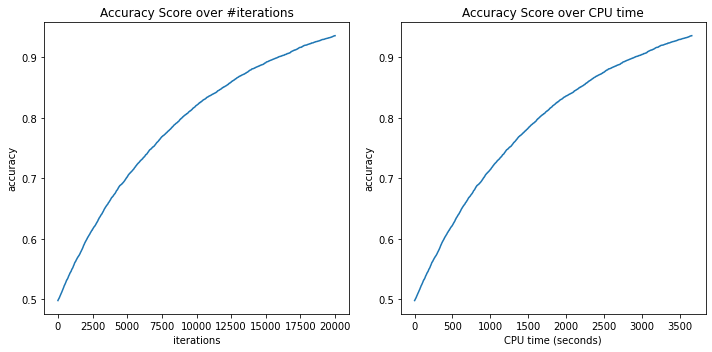

In [ ]:
#~1h, 10m
results_BCGD_rand_nest = BCGD_randomized_nesterov_distribution(y0, y_true, BCGD_stepsizes, S, S_bar, W, W_bar, max_iter = 20000)
print(f'gradient norm: {la.norm(results_BCGD_rand_nest[1])}\nnumber of iterations carried out: {results_BCGD_rand_nest[2]}\nachieved accuracy score: {results_BCGD_rand_nest[3][-1]}')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# let's plot #(iterations) vs accuracy 
axes[0].plot(range(results_BCGD_rand_nest[2]), results_BCGD_rand_nest[3])

# Add title and axis names
axes[0].set_title('Accuracy Score over #iterations')
axes[0].set_xlabel('iterations')
axes[0].set_ylabel('accuracy')


# let's also plot CPU time vs accuracy 
axes[1].plot(results_BCGD_rand_nest[4], results_BCGD_rand_nest[3])

# Add title and axis names
axes[1].set_title('Accuracy Score over CPU time')
axes[1].set_xlabel('CPU time (seconds)')
axes[1].set_ylabel('accuracy')

fig.tight_layout()
plt.show()

gradient norm: 13239.52173193378
number of iterations carried out: 10000
achieved accuracy score: 0.999896960329727


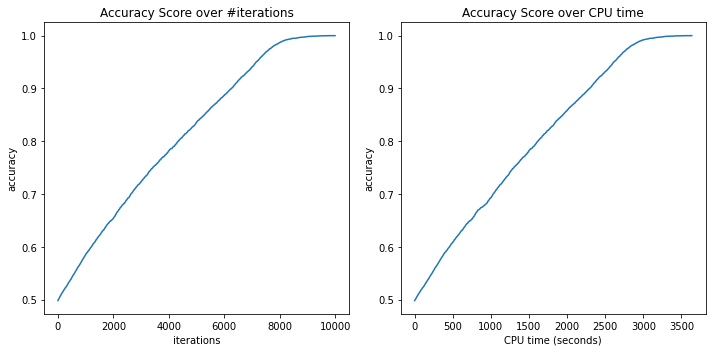

In [ ]:
#~1h 10m
results_BCGD_GS = BCGD_GS(y0, y_true, BCGD_stepsizes, S, S_bar, W, W_bar)
print(f'gradient norm: {la.norm(results_BCGD_GS[1])}\nnumber of iterations carried out: {results_BCGD_GS[2]}\nachieved accuracy score: {results_BCGD_GS[3][-1]}')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# let's plot #(iterations) vs accuracy 
axes[0].plot(range(results_BCGD_GS[2]), results_BCGD_GS[3])

# Add title and axis names
axes[0].set_title('Accuracy Score over #iterations')
axes[0].set_xlabel('iterations')
axes[0].set_ylabel('accuracy')


# let's also plot CPU time vs accuracy 
axes[1].plot(results_BCGD_GS[4], results_BCGD_GS[3])

# Add title and axis names
axes[1].set_title('Accuracy Score over CPU time')
axes[1].set_xlabel('CPU time (seconds)')
axes[1].set_ylabel('accuracy')

fig.tight_layout()
plt.show()

Finally let's plot all togheter to better spot the different behaviours.

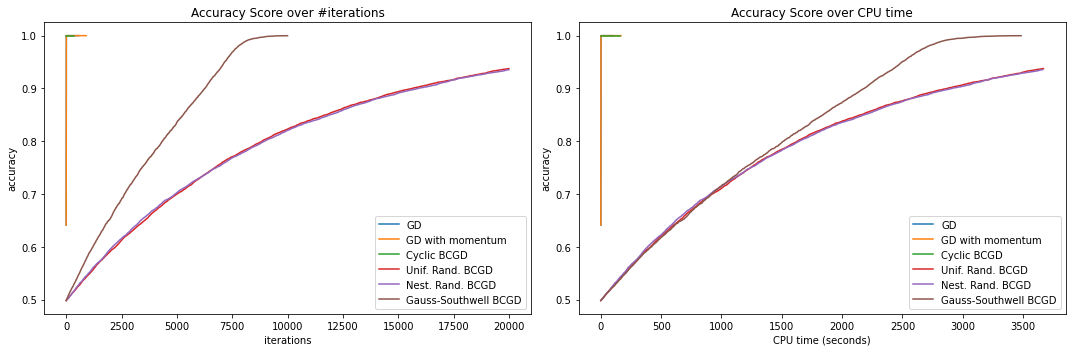

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(range(results_GD[2]), results_GD[3], label='GD')
axes[0].plot(range(results_AGD[2]), results_AGD[3], label='GD with momentum')
axes[0].plot(range(results_BCGD_cyclic[2]), results_BCGD_cyclic[3], label='Cyclic BCGD')
axes[0].plot(range(results_BCGD_rand_unif[2]), results_BCGD_rand_unif[3], label='Unif. Rand. BCGD')
axes[0].plot(range(results_BCGD_rand_nest[2]), results_BCGD_rand_nest[3], label='Nest. Rand. BCGD')
axes[0].plot(range(results_BCGD_GS[2]), results_BCGD_GS[3], label='Gauss-Southwell BCGD')

axes[0].set_title('Accuracy Score over #iterations')
axes[0].set_xlabel('iterations')
axes[0].set_ylabel('accuracy')

axes[0].legend()

axes[1].plot(results_GD[4], results_GD[3], label='GD')
axes[1].plot(results_AGD[4], results_AGD[3], label='GD with momentum')
axes[1].plot(results_BCGD_cyclic[4], results_BCGD_cyclic[3], label='Cyclic BCGD')
axes[1].plot(results_BCGD_rand_unif[4], results_BCGD_rand_unif[3], label='Unif. Rand. BCGD')
axes[1].plot(results_BCGD_rand_nest[4], results_BCGD_rand_nest[3], label='Nest. Rand. BCGD')
axes[1].plot(results_BCGD_GS[4], results_BCGD_GS[3], label='Gauss-Southwell BCGD')

axes[1].set_title('Accuracy Score over CPU time')
axes[1].set_xlabel('CPU time (seconds)')
axes[1].set_ylabel('accuracy')

axes[1].legend()

fig.tight_layout()
plt.show()

### Starting Point with k-NN

gradient norm: 9.694397283899862e-09
number of iterations carried out: 555
achieved accuracy score: 1.0


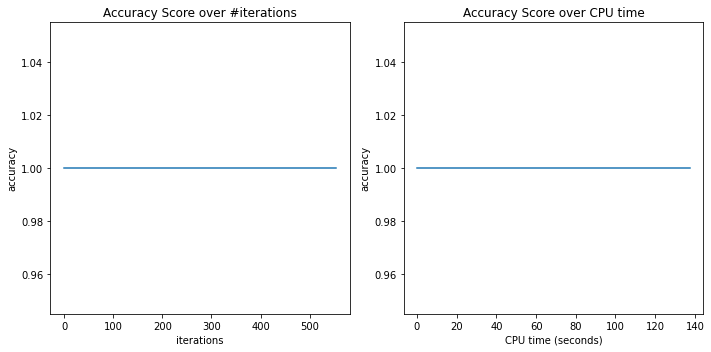

In [ ]:
results_GD = gradient_descent(y0_kNN, y_true, GD_stepsize, S, S_bar, W, W_bar)
print(f'gradient norm: {la.norm(results_GD[1])}\nnumber of iterations carried out: {results_GD[2]}\nachieved accuracy score: {results_GD[3][-1]}')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# let's plot #(iterations) vs accuracy 
axes[0].plot(range(results_GD[2]), results_GD[3])

# Add title and axis names
axes[0].set_title('Accuracy Score over #iterations')
axes[0].set_xlabel('iterations')
axes[0].set_ylabel('accuracy')


# let's also plot CPU time vs accuracy 
axes[1].plot(results_GD[4], results_GD[3])

# Add title and axis names
axes[1].set_title('Accuracy Score over CPU time')
axes[1].set_xlabel('CPU time (seconds)')
axes[1].set_ylabel('accuracy')

fig.tight_layout()
plt.show()

gradient norm: 9.953873961108147e-09
number of iterations carried out: 910
achieved accuracy score: 1.0


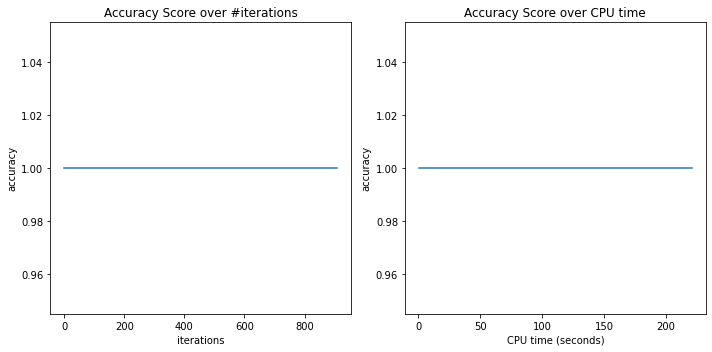

In [ ]:
results_AGD = gradient_descent_nesterov(y0_kNN, y_true, GD_stepsize, S, S_bar, W, W_bar)
print(f'gradient norm: {la.norm(results_AGD[1])}\nnumber of iterations carried out: {results_AGD[2]}\nachieved accuracy score: {results_AGD[3][-1]}')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# let's plot #(iterations) vs accuracy 
axes[0].plot(range(results_AGD[2]), results_AGD[3])

# Add title and axis names
axes[0].set_title('Accuracy Score over #iterations')
axes[0].set_xlabel('iterations')
axes[0].set_ylabel('accuracy')


# let's also plot CPU time vs accuracy 
axes[1].plot(results_AGD[4], results_AGD[3])

# Add title and axis names
axes[1].set_title('Accuracy Score over CPU time')
axes[1].set_xlabel('CPU time (seconds)')
axes[1].set_ylabel('accuracy')

fig.tight_layout()
plt.show()

gradient norm: 9.800710324140765e-09
number of iterations carried out: 376
achieved accuracy score: 1.0


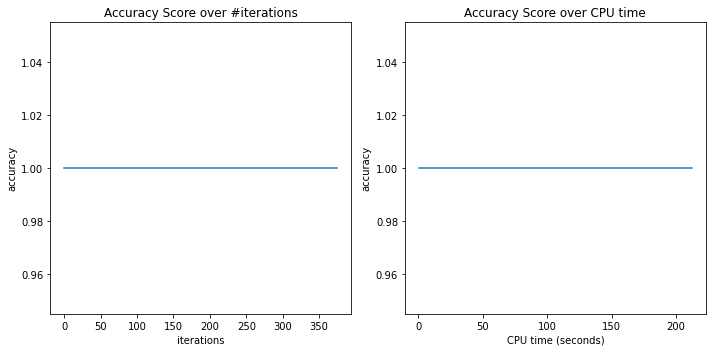

In [ ]:
results_BCGD_cyclic = BCGD_cyclic(y0_kNN, y_true, BCGD_stepsizes, S, S_bar, W, W_bar)
print(f'gradient norm: {la.norm(results_BCGD_cyclic[1])}\nnumber of iterations carried out: {results_BCGD_cyclic[2]}\nachieved accuracy score: {results_BCGD_cyclic[3][-1]}')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# let's plot #(iterations) vs accuracy 
axes[0].plot(range(results_BCGD_cyclic[2]), results_BCGD_cyclic[3])

# Add title and axis names
axes[0].set_title('Accuracy Score over #iterations')
axes[0].set_xlabel('iterations')
axes[0].set_ylabel('accuracy')


# let's also plot CPU time vs accuracy 
axes[1].plot(results_BCGD_cyclic[4], results_BCGD_cyclic[3])

# Add title and axis names
axes[1].set_title('Accuracy Score over CPU time')
axes[1].set_xlabel('CPU time (seconds)')
axes[1].set_ylabel('accuracy')

fig.tight_layout()
plt.show()

gradient norm: 19936.88106506538
number of iterations carried out: 10000
achieved accuracy score: 1.0


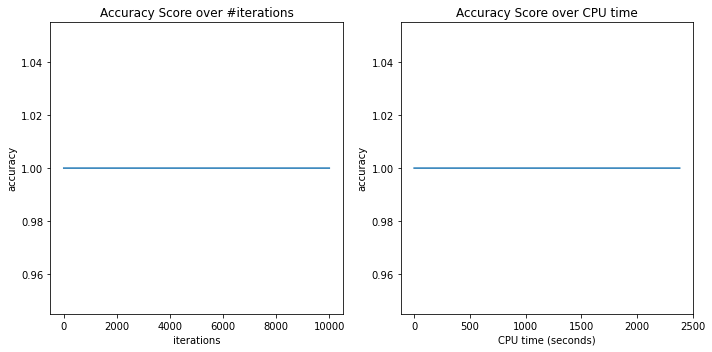

In [ ]:
results_BCGD_rand_unif = BCGD_randomized_uniform_distribution(y0_kNN, y_true, BCGD_stepsizes, S, S_bar, W, W_bar)
print(f'gradient norm: {la.norm(results_BCGD_rand_unif[1])}\nnumber of iterations carried out: {results_BCGD_rand_unif[2]}\nachieved accuracy score: {results_BCGD_rand_unif[3][-1]}')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# let's plot #(iterations) vs accuracy 
axes[0].plot(range(results_BCGD_rand_unif[2]), results_BCGD_rand_unif[3])

# Add title and axis names
axes[0].set_title('Accuracy Score over #iterations')
axes[0].set_xlabel('iterations')
axes[0].set_ylabel('accuracy')


# let's also plot CPU time vs accuracy 
axes[1].plot(results_BCGD_rand_unif[4], results_BCGD_rand_unif[3])

# Add title and axis names
axes[1].set_title('Accuracy Score over CPU time')
axes[1].set_xlabel('CPU time (seconds)')
axes[1].set_ylabel('accuracy')

fig.tight_layout()
plt.show()

gradient norm: 19988.98084686475
number of iterations carried out: 10000
achieved accuracy score: 1.0


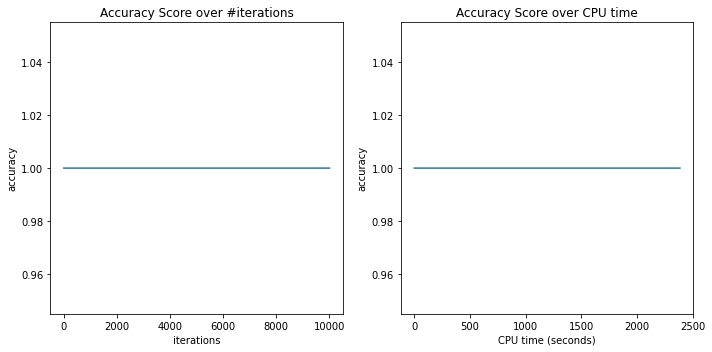

In [ ]:
#~1h, 10m
results_BCGD_rand_nest = BCGD_randomized_nesterov_distribution(y0_kNN, y_true, BCGD_stepsizes, S, S_bar, W, W_bar)
print(f'gradient norm: {la.norm(results_BCGD_rand_nest[1])}\nnumber of iterations carried out: {results_BCGD_rand_nest[2]}\nachieved accuracy score: {results_BCGD_rand_nest[3][-1]}')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# let's plot #(iterations) vs accuracy 
axes[0].plot(range(results_BCGD_rand_nest[2]), results_BCGD_rand_nest[3])

# Add title and axis names
axes[0].set_title('Accuracy Score over #iterations')
axes[0].set_xlabel('iterations')
axes[0].set_ylabel('accuracy')


# let's also plot CPU time vs accuracy 
axes[1].plot(results_BCGD_rand_nest[4], results_BCGD_rand_nest[3])

# Add title and axis names
axes[1].set_title('Accuracy Score over CPU time')
axes[1].set_xlabel('CPU time (seconds)')
axes[1].set_ylabel('accuracy')

fig.tight_layout()
plt.show()

gradient norm: 15569.232322297165
number of iterations carried out: 10000
achieved accuracy score: 1.0


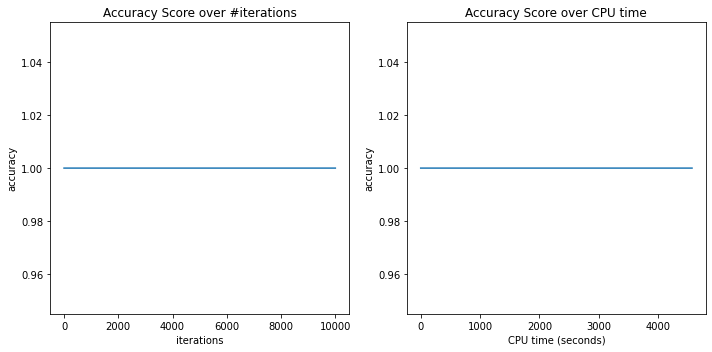

In [ ]:
results_BCGD_GS = BCGD_GS(y0_kNN, y_true, BCGD_stepsizes, S, S_bar, W, W_bar)
print(f'gradient norm: {la.norm(results_BCGD_GS[1])}\nnumber of iterations carried out: {results_BCGD_GS[2]}\nachieved accuracy score: {results_BCGD_GS[3][-1]}')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# let's plot #(iterations) vs accuracy 
axes[0].plot(range(results_BCGD_GS[2]), results_BCGD_GS[3])

# Add title and axis names
axes[0].set_title('Accuracy Score over #iterations')
axes[0].set_xlabel('iterations')
axes[0].set_ylabel('accuracy')


# let's also plot CPU time vs accuracy 
axes[1].plot(results_BCGD_GS[4], results_BCGD_GS[3])

# Add title and axis names
axes[1].set_title('Accuracy Score over CPU time')
axes[1].set_xlabel('CPU time (seconds)')
axes[1].set_ylabel('accuracy')

fig.tight_layout()
plt.show()

Finally let's plot all togheter to better spot the different behaviours.

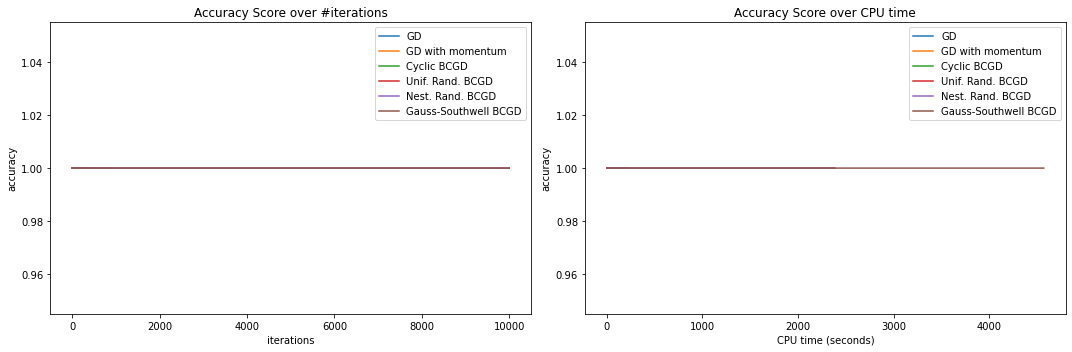

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(range(results_GD[2]), results_GD[3], label='GD')
axes[0].plot(range(results_AGD[2]), results_AGD[3], label='GD with momentum')
axes[0].plot(range(results_BCGD_cyclic[2]), results_BCGD_cyclic[3], label='Cyclic BCGD')
axes[0].plot(range(results_BCGD_rand_unif[2]), results_BCGD_rand_unif[3], label='Unif. Rand. BCGD')
axes[0].plot(range(results_BCGD_rand_nest[2]), results_BCGD_rand_nest[3], label='Nest. Rand. BCGD')
axes[0].plot(range(results_BCGD_GS[2]), results_BCGD_GS[3], label='Gauss-Southwell BCGD')

axes[0].set_title('Accuracy Score over #iterations')
axes[0].set_xlabel('iterations')
axes[0].set_ylabel('accuracy')

axes[0].legend()

axes[1].plot(results_GD[4], results_GD[3], label='GD')
axes[1].plot(results_AGD[4], results_AGD[3], label='GD with momentum')
axes[1].plot(results_BCGD_cyclic[4], results_BCGD_cyclic[3], label='Cyclic BCGD')
axes[1].plot(results_BCGD_rand_unif[4], results_BCGD_rand_unif[3], label='Unif. Rand. BCGD')
axes[1].plot(results_BCGD_rand_nest[4], results_BCGD_rand_nest[3], label='Nest. Rand. BCGD')
axes[1].plot(results_BCGD_GS[4], results_BCGD_GS[3], label='Gauss-Southwell BCGD')

axes[1].set_title('Accuracy Score over CPU time')
axes[1].set_xlabel('CPU time (seconds)')
axes[1].set_ylabel('accuracy')

axes[1].legend()

fig.tight_layout()
plt.show()

# Real Dataset picked from UCI data sets

## Initialization

The dataset we'll use is the Census Income dataset, which can be found [here](https://archive.ics.uci.edu/ml/datasets/Adult).\
The original dataset consists of 48842 instances and 14 features, even though for computational reasons we imported just the training set, which contains 32561 observations. The goal is to predict whether the income exceeds $50K/yr based on census data.\
So we're dealing with a binary classification problem where the features are:\
age, workclass, fnlwgt, education, education_num, marital_status, occupation, relationship, race, sex, capital-gain, capital-loss, hours-per-week, native-country.\
To begin let's import the dataset using the file adult.data, which consists of comma separated values.

In [ ]:
file_path = 'adult.data'
col_names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

dataset = pd.read_csv(file_path, sep=', ', header=None, na_values=["?"], index_col=False, names = col_names)

print(f'dimension of full dataset: {dataset.shape}')

# since working with the entire dataset is computationally too expensive, we'll select only the first 10K rows
dataset = dataset.iloc[:10000, :]
print(f'dimension of reduced dataset: {dataset.shape}')

# let's have a look at the first five rows
dataset.head()

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


dimension of full dataset: (32561, 15)
dimension of reduced dataset: (10000, 15)


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


As one of the most important preliminary steps, we check for potential missing values. From the dataset description we know that missing values are encoded with the character '?'. Our strategy will be to drop every row containing at least one of such values.

In [ ]:
# check number of missing values per column
print(f'\nmissing values per column:\n {np.sum(dataset.isna())}')

# drop rows with missing values
dataset.dropna(how='any', inplace=True)

# check again number of missing values per column
print(f'\nmissing values per column after dropna:\n {np.sum(dataset.isna())}')

# new dimension after dropping nan values
print(f'\ndimension of dataset after NaN removal: {dataset.shape}')


missing values per column:
 age                 0
workclass         585
fnlwgt              0
education           0
education_num       0
marital_status      0
occupation        586
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    181
income              0
dtype: int64

missing values per column after dropna:
 age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

dimension of dataset after NaN removal: (9244, 15)


the dataset is now clean! Let's start working on it


In [ ]:
# let's change the target values to -1, +1
dataset.loc[dataset['income']=='<=50K', 'income'] = -1
dataset.loc[dataset['income']=='>50K', 'income'] = 1  

# and let's separate features from labels
X = dataset.loc[:,:'native-country']
y = np.array(dataset.loc[:, 'income'])

# let's check the data type for each feature
print('\ndata type per column:\n')
print(X.info())


data type per column:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9244 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             9244 non-null   int64 
 1   workclass       9244 non-null   object
 2   fnlwgt          9244 non-null   int64 
 3   education       9244 non-null   object
 4   education_num   9244 non-null   int64 
 5   marital_status  9244 non-null   object
 6   occupation      9244 non-null   object
 7   relationship    9244 non-null   object
 8   race            9244 non-null   object
 9   sex             9244 non-null   object
 10  capital-gain    9244 non-null   int64 
 11  capital-loss    9244 non-null   int64 
 12  hours-per-week  9244 non-null   int64 
 13  native-country  9244 non-null   object
dtypes: int64(6), object(8)
memory usage: 1.1+ MB
None


some features are categorical, we need to one-hot encode them before start working on the dataset.

In [ ]:
# we want to encode columns which have a string data type
cols_to_encode = [col for col in X.columns if is_string_dtype(X[col])]
# one-hot encoding
X = pd.get_dummies(X, cols_to_encode)

# finally let's convert X to a numpy array
X = np.array(X, float)

# dimension of dataset after one-hot encoding
print(f'dimension of dataset after one-hot encoding: {X.shape}')

dimension of dataset after one-hot encoding: (9244, 103)


To conclude the preprocessing phase, let's now discard all but 3% of the total amount of labels

In [ ]:
print(f'labels: {np.unique(y)}')

# let's discard all but 3% of labels out of the entire dataset. We'll to this by generating a set of random indexes for which we'll keep the labels
np.random.seed(42)
# indexes for which to keep the labels
labeled = np.sort(np.unique(np.random.randint(0, high=y.shape[0], size=int(y.shape[0]*3/100), dtype=int)))
#print(labeled)


# indexes for which we'll discard the labels
unlabeled = np.sort(np.array(list(set(range(y.shape[0]))-set(labeled))))
#print(unlabeled)

# save the discarded labels in y_true to compute accuracy later on
y_true = y[unlabeled]

# discard labels
y[unlabeled]=0

print(f'# unlabeled examples: {sum(y==0)}\n# labeled examples: {sum((y==-1)+(y==1))}')

labels: [-1 1]
# unlabeled examples: 8971
# labeled examples: 273


## Weight Matrices and Lipschitz constants

Let's compute the weights matrices (~38 minutes).

In [ ]:
# similarity measure between labeled-unlabeled
def similarity_LabUnlab(x1,x2, sigma = 100):
  return np.exp(-0.5*la.norm(x1-x2)/np.power(sigma,2))

# similarity measure between unlabeled-unlabeled
def similarity_UnlabUnlab(x1,x2, sigma = 100):
  return np.exp(-0.5*la.norm(x1-x2)/np.power(sigma,2))

# we initialize the weight matrices setting all entries to zero
W = np.zeros((labeled.shape[0], unlabeled.shape[0]))
W_bar = np.zeros((unlabeled.shape[0], unlabeled.shape[0]))

# we then fill every entry with the similarity measures defined above
for i in range(W.shape[0]):
  for j in range(W.shape[1]):    
    W[i,j] = similarity_LabUnlab(X[labeled[i],:],X[unlabeled[j],:])

for i in range(W_bar.shape[0]):
  for j in range(W_bar.shape[1]):    
    W_bar[i,j] = similarity_UnlabUnlab(X[unlabeled[i],:],X[unlabeled[j],:])

# let's check if W_bar is symmetric
print(f'W_bar is symmetric: {(W_bar==W_bar.T).all()}')

W_bar is symmetric: True


let's compute the Lipschitz constants for the various gradients (~28 minutes)

In [ ]:
S = np.sum(W, axis=0) # vector whose component S[j] is the sum of values of the j-th column of W
S_bar = np.sum(W_bar, axis=0) # vector whose component S_bar[j] is the sum of values of the j-th column of W_bar
y_bar = y[labeled]

# Lipschitz constants and optimal fixed stepsizes for GD's
L = 2*la.norm(np.diag(S+S_bar)-W_bar, 2) # Lipschitz constant for the gradient of f
GD_stepsize = 1.0/L # optimal fixed stepsize for Gradient Descent methods
L_k = 2*(S+S_bar-np.diag(W_bar)) # block-wise Lipschitz constants for the gradient of f
BCGD_stepsizes = 1.0/L_k # optimal fixed stepsizes for Block Coordinate Gradient Descent methods

Let's then define the starting points for our iterative algorithms.

In [ ]:
# random starting point, where each component is picked at random uniformly in [-1, 1]
np.random.seed(423)
y0 = 2*np.random.rand(unlabeled.shape[0])-1

# starting point based on k-nearest neighbor
def k_neighbors(P, dataset, k):
  neighs = {} # we use this dictionary to save indexes of neighbors and their respective distances from point P
  for i in range(dataset.shape[0]):
    neighs[i] = la.norm(P - dataset[i,:])
  lst = list(neighs.items()) # list of tuples (index, distance) to track the neighbors of point P
  lst.sort(key=lambda x: x[1], reverse=False) # we sort the list by distance in ascending order
  return lst[:k] # we return (index, distance) for the k-nearest neighbors

# for each unlabeled point let's calculate its k-nearest neighbors among the labeled points
y0_kNN = np.zeros(unlabeled.shape[0])
k = 8
neighbors = {} # for each unlabeled point we store the index of the k-nearest neighbors among the labeled points
for i in range(unlabeled.shape[0]):
  neighbors[i] =[tpl[0] for tpl in k_neighbors(X[unlabeled[i]], X[labeled], k)]
  classes = [] # we want to assign the point the most frequent label among the k-nearest neighbor
  for index in neighbors[i]:    
    classes.append(y[labeled[index]]) # for each k-nearest neighbor we look at the label
  y0_kNN[i] = mode(classes)[0][0] # we assign the point the most frequent label among its k-nearest neighbors

print(y0_kNN)

[-1. -1. -1. ... -1. -1. -1.]


## Algorithms application

### Randomly generated Starting Point

gradient norm: 0.3615881769562145
number of iterations carried out: 10000
achieved accuracy score: 0.7547653550328838


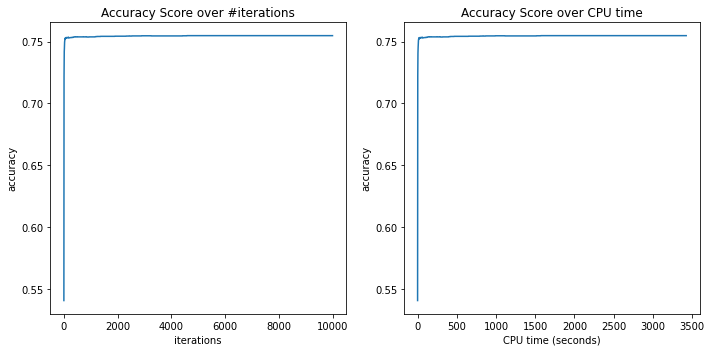

In [ ]:
results_GD = gradient_descent(y0, y_true, GD_stepsize, S, S_bar, W, W_bar)
print(f'gradient norm: {la.norm(results_GD[1])}\nnumber of iterations carried out: {results_GD[2]}\nachieved accuracy score: {results_GD[3][-1]}')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# let's plot #(iterations) vs accuracy 
axes[0].plot(range(results_GD[2]), results_GD[3])

# Add title and axis names
axes[0].set_title('Accuracy Score over #iterations')
axes[0].set_xlabel('iterations')
axes[0].set_ylabel('accuracy')


# let's also plot CPU time vs accuracy 
axes[1].plot(results_GD[4], results_GD[3])

# Add title and axis names
axes[1].set_title('Accuracy Score over CPU time')
axes[1].set_xlabel('CPU time (seconds)')
axes[1].set_ylabel('accuracy')

fig.tight_layout()
plt.show()

gradient norm: 0.3622476841908227
number of iterations carried out: 10000
achieved accuracy score: 0.7547653550328838


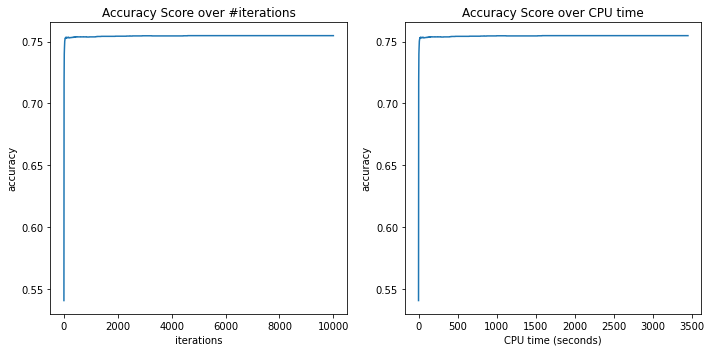

In [ ]:
results_AGD = gradient_descent_nesterov(y0, y_true, GD_stepsize, S, S_bar, W, W_bar)
print(f'gradient norm: {la.norm(results_AGD[1])}\nnumber of iterations carried out: {results_AGD[2]}\nachieved accuracy score: {results_AGD[3][-1]}')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# let's plot #(iterations) vs accuracy 
axes[0].plot(range(results_AGD[2]), results_AGD[3])

# Add title and axis names
axes[0].set_title('Accuracy Score over #iterations')
axes[0].set_xlabel('iterations')
axes[0].set_ylabel('accuracy')


# let's also plot CPU time vs accuracy 
axes[1].plot(results_AGD[4], results_AGD[3])

# Add title and axis names
axes[1].set_title('Accuracy Score over CPU time')
axes[1].set_xlabel('CPU time (seconds)')
axes[1].set_ylabel('accuracy')

fig.tight_layout()
plt.show()

gradient norm: 9.967333160791496e-09
number of iterations carried out: 1108
achieved accuracy score: 0.7547653550328838


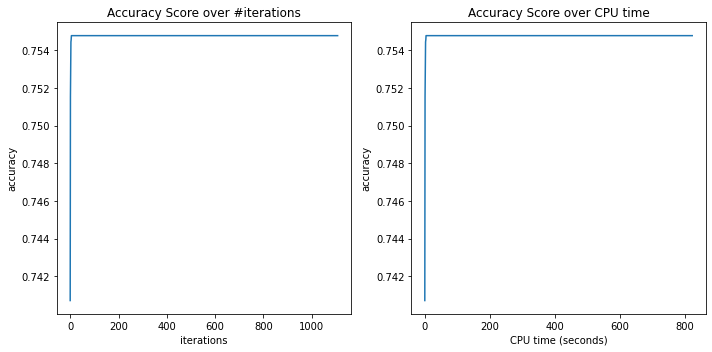

In [ ]:
results_BCGD_cyclic = BCGD_cyclic(y0, y_true, BCGD_stepsizes, S, S_bar, W, W_bar)
print(f'gradient norm: {la.norm(results_BCGD_cyclic[1])}\nnumber of iterations carried out: {results_BCGD_cyclic[2]}\nachieved accuracy score: {results_BCGD_cyclic[3][-1]}')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# let's plot #(iterations) vs accuracy 
axes[0].plot(range(results_BCGD_cyclic[2]), results_BCGD_cyclic[3])

# Add title and axis names
axes[0].set_title('Accuracy Score over #iterations')
axes[0].set_xlabel('iterations')
axes[0].set_ylabel('accuracy')


# let's also plot CPU time vs accuracy 
axes[1].plot(results_BCGD_cyclic[4], results_BCGD_cyclic[3])

# Add title and axis names
axes[1].set_title('Accuracy Score over CPU time')
axes[1].set_xlabel('CPU time (seconds)')
axes[1].set_ylabel('accuracy')

fig.tight_layout()
plt.show()

gradient norm: 74594.98780739865
number of iterations carried out: 10000
achieved accuracy score: 0.6563370861665366


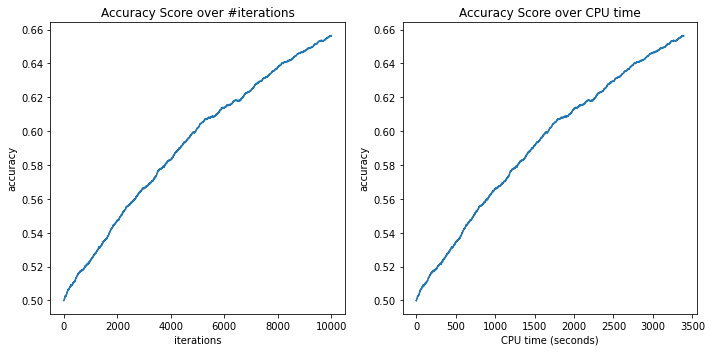

In [ ]:
results_BCGD_rand_unif = BCGD_randomized_uniform_distribution(y0, y_true, BCGD_stepsizes, S, S_bar, W, W_bar)
print(f'gradient norm: {la.norm(results_BCGD_rand_unif[1])}\nnumber of iterations carried out: {results_BCGD_rand_unif[2]}\nachieved accuracy score: {results_BCGD_rand_unif[3][-1]}')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# let's plot #(iterations) vs accuracy 
axes[0].plot(range(results_BCGD_rand_unif[2]), results_BCGD_rand_unif[3])

# Add title and axis names
axes[0].set_title('Accuracy Score over #iterations')
axes[0].set_xlabel('iterations')
axes[0].set_ylabel('accuracy')


# let's also plot CPU time vs accuracy 
axes[1].plot(results_BCGD_rand_unif[4], results_BCGD_rand_unif[3])

# Add title and axis names
axes[1].set_title('Accuracy Score over CPU time')
axes[1].set_xlabel('CPU time (seconds)')
axes[1].set_ylabel('accuracy')

fig.tight_layout()
plt.show()

gradient norm: 64817.457507897096
number of iterations carried out: 10000
achieved accuracy score: 0.6470850518336864


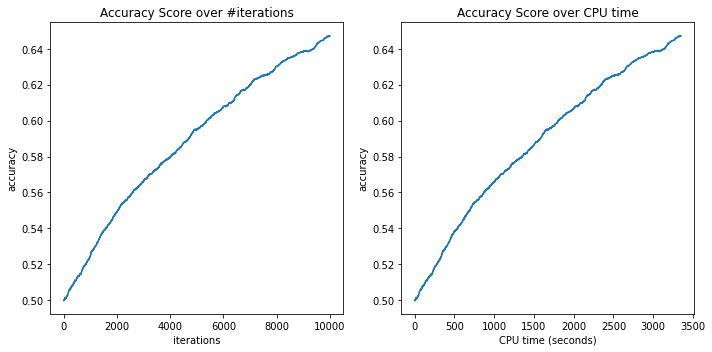

In [ ]:
results_BCGD_rand_nest = BCGD_randomized_nesterov_distribution(y0, y_true, BCGD_stepsizes, S, S_bar, W, W_bar)
print(f'gradient norm: {la.norm(results_BCGD_rand_nest[1])}\nnumber of iterations carried out: {results_BCGD_rand_nest[2]}\nachieved accuracy score: {results_BCGD_rand_nest[3][-1]}')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# let's plot #(iterations) vs accuracy 
axes[0].plot(range(results_BCGD_rand_nest[2]), results_BCGD_rand_nest[3])

# Add title and axis names
axes[0].set_title('Accuracy Score over #iterations')
axes[0].set_xlabel('iterations')
axes[0].set_ylabel('accuracy')


# let's also plot CPU time vs accuracy 
axes[1].plot(results_BCGD_rand_nest[4], results_BCGD_rand_nest[3])

# Add title and axis names
axes[1].set_title('Accuracy Score over CPU time')
axes[1].set_xlabel('CPU time (seconds)')
axes[1].set_ylabel('accuracy')

fig.tight_layout()
plt.show()

gradient norm: 3836.3564099253636
number of iterations carried out: 10000
achieved accuracy score: 0.7487459592018727


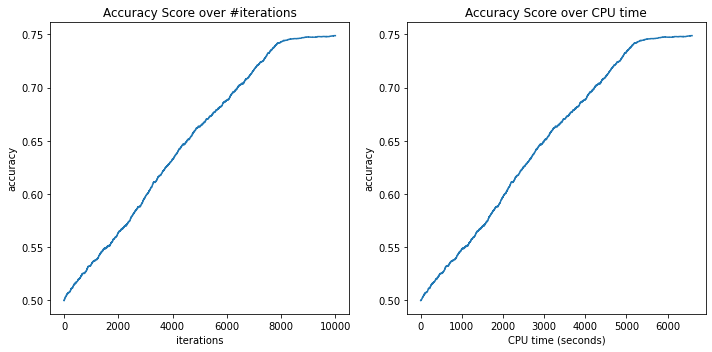

In [ ]:
results_BCGD_GS = BCGD_GS(y0, y_true, BCGD_stepsizes, S, S_bar, W, W_bar)
print(f'gradient norm: {la.norm(results_BCGD_GS[1])}\nnumber of iterations carried out: {results_BCGD_GS[2]}\nachieved accuracy score: {results_BCGD_GS[3][-1]}')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# let's plot #(iterations) vs accuracy 
axes[0].plot(range(results_BCGD_GS[2]), results_BCGD_GS[3])

# Add title and axis names
axes[0].set_title('Accuracy Score over #iterations')
axes[0].set_xlabel('iterations')
axes[0].set_ylabel('accuracy')


# let's also plot CPU time vs accuracy 
axes[1].plot(results_BCGD_GS[4], results_BCGD_GS[3])

# Add title and axis names
axes[1].set_title('Accuracy Score over CPU time')
axes[1].set_xlabel('CPU time (seconds)')
axes[1].set_ylabel('accuracy')

fig.tight_layout()
plt.show()

Finally let's plot all togheter to better spot the different behaviours.

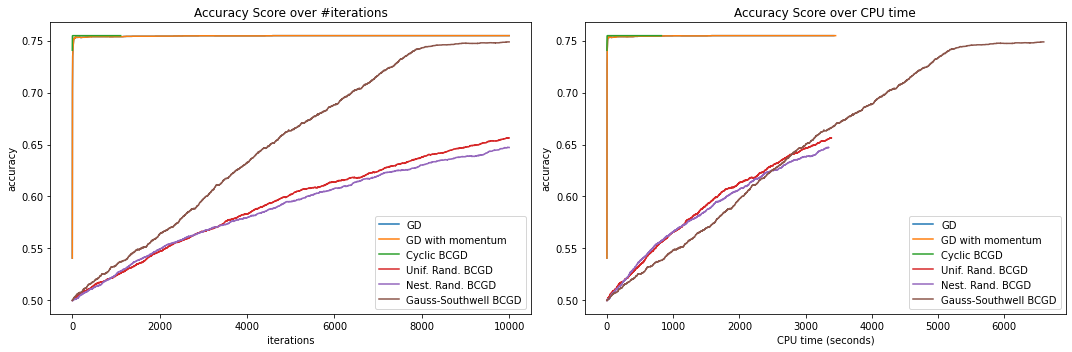

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(range(results_GD[2]), results_GD[3], label='GD')
axes[0].plot(range(results_AGD[2]), results_AGD[3], label='GD with momentum')
axes[0].plot(range(results_BCGD_cyclic[2]), results_BCGD_cyclic[3], label='Cyclic BCGD')
axes[0].plot(range(results_BCGD_rand_unif[2]), results_BCGD_rand_unif[3], label='Unif. Rand. BCGD')
axes[0].plot(range(results_BCGD_rand_nest[2]), results_BCGD_rand_nest[3], label='Nest. Rand. BCGD')
axes[0].plot(range(results_BCGD_GS[2]), results_BCGD_GS[3], label='Gauss-Southwell BCGD')

axes[0].set_title('Accuracy Score over #iterations')
axes[0].set_xlabel('iterations')
axes[0].set_ylabel('accuracy')

axes[0].legend()

axes[1].plot(results_GD[4], results_GD[3], label='GD')
axes[1].plot(results_AGD[4], results_AGD[3], label='GD with momentum')
axes[1].plot(results_BCGD_cyclic[4], results_BCGD_cyclic[3], label='Cyclic BCGD')
axes[1].plot(results_BCGD_rand_unif[4], results_BCGD_rand_unif[3], label='Unif. Rand. BCGD')
axes[1].plot(results_BCGD_rand_nest[4], results_BCGD_rand_nest[3], label='Nest. Rand. BCGD')
axes[1].plot(results_BCGD_GS[4], results_BCGD_GS[3], label='Gauss-Southwell BCGD')

axes[1].set_title('Accuracy Score over CPU time')
axes[1].set_xlabel('CPU time (seconds)')
axes[1].set_ylabel('accuracy')

axes[1].legend()

fig.tight_layout()
plt.show()

### Starting Point with k-NN

gradient norm: 0.23468250636166496
number of iterations carried out: 10000
achieved accuracy score: 0.7547653550328838


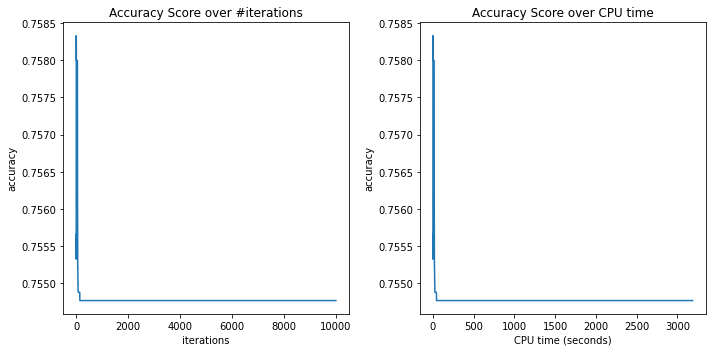

In [ ]:
results_GD = gradient_descent(y0_kNN, y_true, GD_stepsize, S, S_bar, W, W_bar)
print(f'gradient norm: {la.norm(results_GD[1])}\nnumber of iterations carried out: {results_GD[2]}\nachieved accuracy score: {results_GD[3][-1]}')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# let's plot #(iterations) vs accuracy 
axes[0].plot(range(results_GD[2]), results_GD[3])

# Add title and axis names
axes[0].set_title('Accuracy Score over #iterations')
axes[0].set_xlabel('iterations')
axes[0].set_ylabel('accuracy')


# let's also plot CPU time vs accuracy 
axes[1].plot(results_GD[4], results_GD[3])

# Add title and axis names
axes[1].set_title('Accuracy Score over CPU time')
axes[1].set_xlabel('CPU time (seconds)')
axes[1].set_ylabel('accuracy')

fig.tight_layout()
plt.show()

gradient norm: 0.23533133957717403
number of iterations carried out: 10000
achieved accuracy score: 0.7547653550328838


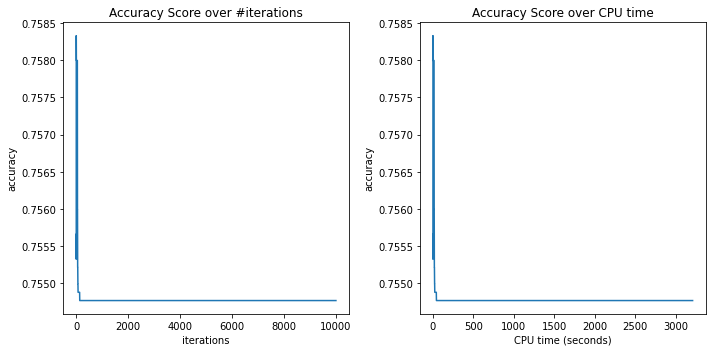

In [ ]:
results_AGD = gradient_descent_nesterov(y0_kNN, y_true, GD_stepsize, S, S_bar, W, W_bar)
print(f'gradient norm: {la.norm(results_AGD[1])}\nnumber of iterations carried out: {results_AGD[2]}\nachieved accuracy score: {results_AGD[3][-1]}')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# let's plot #(iterations) vs accuracy 
axes[0].plot(range(results_AGD[2]), results_AGD[3])

# Add title and axis names
axes[0].set_title('Accuracy Score over #iterations')
axes[0].set_xlabel('iterations')
axes[0].set_ylabel('accuracy')


# let's also plot CPU time vs accuracy 
axes[1].plot(results_AGD[4], results_AGD[3])

# Add title and axis names
axes[1].set_title('Accuracy Score over CPU time')
axes[1].set_xlabel('CPU time (seconds)')
axes[1].set_ylabel('accuracy')

fig.tight_layout()
plt.show()

gradient norm: 9.947670588218157e-09
number of iterations carried out: 692
achieved accuracy score: 0.7547653550328838


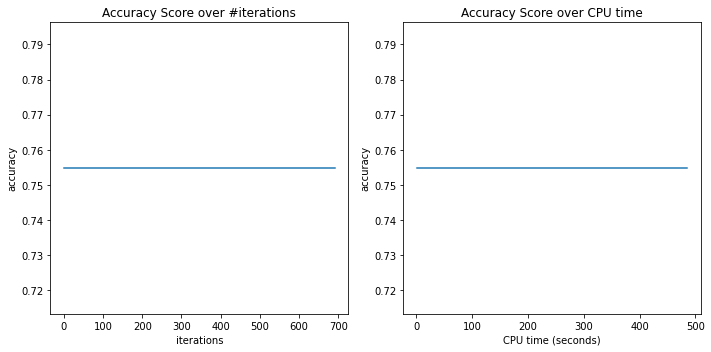

In [ ]:
results_BCGD_cyclic = BCGD_cyclic(y0_kNN, y_true, BCGD_stepsizes, S, S_bar, W, W_bar)
print(f'gradient norm: {la.norm(results_BCGD_cyclic[1])}\nnumber of iterations carried out: {results_BCGD_cyclic[2]}\nachieved accuracy score: {results_BCGD_cyclic[3][-1]}')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# let's plot #(iterations) vs accuracy 
axes[0].plot(range(results_BCGD_cyclic[2]), results_BCGD_cyclic[3])

# Add title and axis names
axes[0].set_title('Accuracy Score over #iterations')
axes[0].set_xlabel('iterations')
axes[0].set_ylabel('accuracy')


# let's also plot CPU time vs accuracy 
axes[1].plot(results_BCGD_cyclic[4], results_BCGD_cyclic[3])

# Add title and axis names
axes[1].set_title('Accuracy Score over CPU time')
axes[1].set_xlabel('CPU time (seconds)')
axes[1].set_ylabel('accuracy')

fig.tight_layout()
plt.show()

gradient norm: 18432.55068715236
number of iterations carried out: 10000
achieved accuracy score: 0.7556571173782187


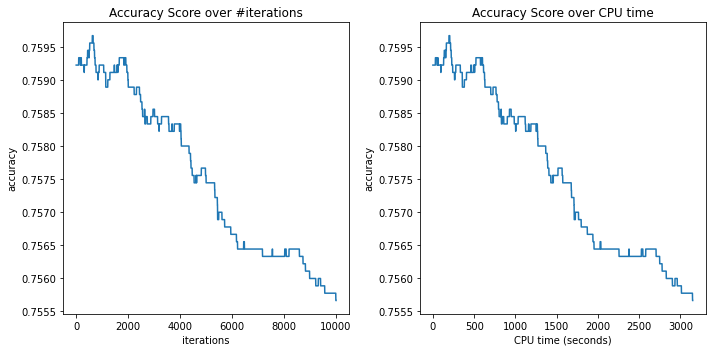

In [ ]:
results_BCGD_rand_unif = BCGD_randomized_uniform_distribution(y0_kNN, y_true, BCGD_stepsizes, S, S_bar, W, W_bar)
print(f'gradient norm: {la.norm(results_BCGD_rand_unif[1])}\nnumber of iterations carried out: {results_BCGD_rand_unif[2]}\nachieved accuracy score: {results_BCGD_rand_unif[3][-1]}')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# let's plot #(iterations) vs accuracy 
axes[0].plot(range(results_BCGD_rand_unif[2]), results_BCGD_rand_unif[3])

# Add title and axis names
axes[0].set_title('Accuracy Score over #iterations')
axes[0].set_xlabel('iterations')
axes[0].set_ylabel('accuracy')


# let's also plot CPU time vs accuracy 
axes[1].plot(results_BCGD_rand_unif[4], results_BCGD_rand_unif[3])

# Add title and axis names
axes[1].set_title('Accuracy Score over CPU time')
axes[1].set_xlabel('CPU time (seconds)')
axes[1].set_ylabel('accuracy')

fig.tight_layout()
plt.show()

gradient norm: 19789.96192299067
number of iterations carried out: 10000
achieved accuracy score: 0.7575521123620556


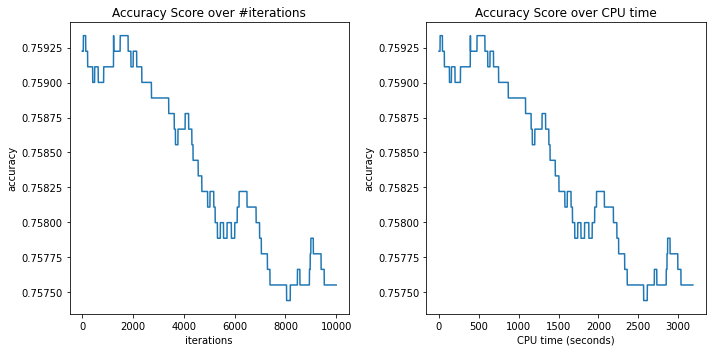

In [ ]:
results_BCGD_rand_nest = BCGD_randomized_nesterov_distribution(y0_kNN, y_true, BCGD_stepsizes, S, S_bar, W, W_bar)
print(f'gradient norm: {la.norm(results_BCGD_rand_nest[1])}\nnumber of iterations carried out: {results_BCGD_rand_nest[2]}\nachieved accuracy score: {results_BCGD_rand_nest[3][-1]}')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# let's plot #(iterations) vs accuracy 
axes[0].plot(range(results_BCGD_rand_nest[2]), results_BCGD_rand_nest[3])

# Add title and axis names
axes[0].set_title('Accuracy Score over #iterations')
axes[0].set_xlabel('iterations')
axes[0].set_ylabel('accuracy')


# let's also plot CPU time vs accuracy 
axes[1].plot(results_BCGD_rand_nest[4], results_BCGD_rand_nest[3])

# Add title and axis names
axes[1].set_title('Accuracy Score over CPU time')
axes[1].set_xlabel('CPU time (seconds)')
axes[1].set_ylabel('accuracy')

fig.tight_layout()
plt.show()

gradient norm: 3192.008570125373
number of iterations carried out: 10000
achieved accuracy score: 0.7548768253260506


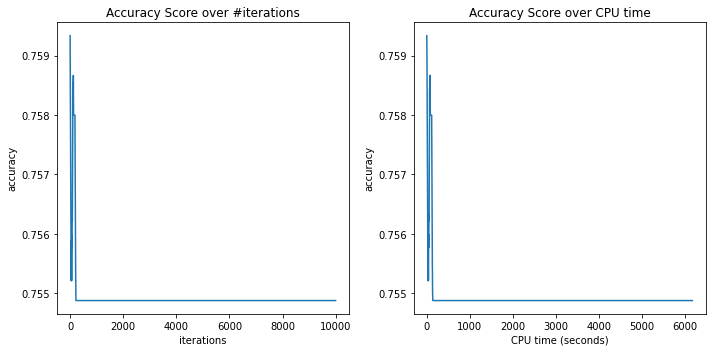

In [ ]:
results_BCGD_GS = BCGD_GS(y0_kNN, y_true, BCGD_stepsizes, S, S_bar, W, W_bar)
print(f'gradient norm: {la.norm(results_BCGD_GS[1])}\nnumber of iterations carried out: {results_BCGD_GS[2]}\nachieved accuracy score: {results_BCGD_GS[3][-1]}')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# let's plot #(iterations) vs accuracy 
axes[0].plot(range(results_BCGD_GS[2]), results_BCGD_GS[3])

# Add title and axis names
axes[0].set_title('Accuracy Score over #iterations')
axes[0].set_xlabel('iterations')
axes[0].set_ylabel('accuracy')


# let's also plot CPU time vs accuracy 
axes[1].plot(results_BCGD_GS[4], results_BCGD_GS[3])

# Add title and axis names
axes[1].set_title('Accuracy Score over CPU time')
axes[1].set_xlabel('CPU time (seconds)')
axes[1].set_ylabel('accuracy')

fig.tight_layout()
plt.show()

Finally let's plot all togheter to better spot the different behaviours.

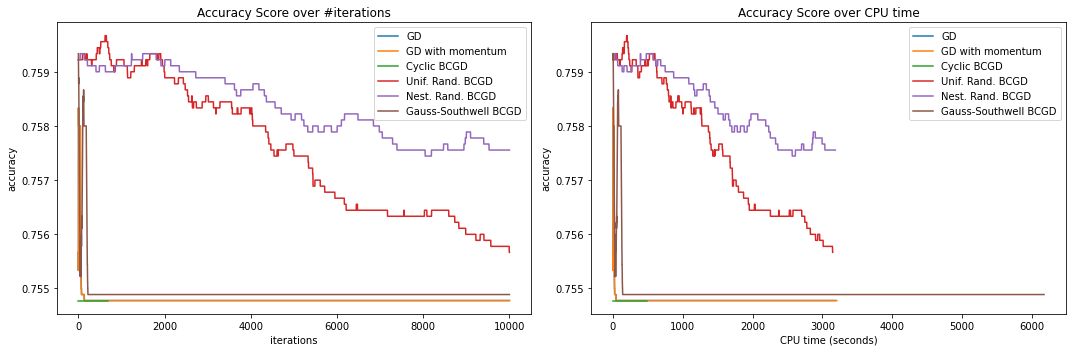

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(range(results_GD[2]), results_GD[3], label='GD')
axes[0].plot(range(results_AGD[2]), results_AGD[3], label='GD with momentum')
axes[0].plot(range(results_BCGD_cyclic[2]), results_BCGD_cyclic[3], label='Cyclic BCGD')
axes[0].plot(range(results_BCGD_rand_unif[2]), results_BCGD_rand_unif[3], label='Unif. Rand. BCGD')
axes[0].plot(range(results_BCGD_rand_nest[2]), results_BCGD_rand_nest[3], label='Nest. Rand. BCGD')
axes[0].plot(range(results_BCGD_GS[2]), results_BCGD_GS[3], label='Gauss-Southwell BCGD')

axes[0].set_title('Accuracy Score over #iterations')
axes[0].set_xlabel('iterations')
axes[0].set_ylabel('accuracy')

axes[0].legend()

axes[1].plot(results_GD[4], results_GD[3], label='GD')
axes[1].plot(results_AGD[4], results_AGD[3], label='GD with momentum')
axes[1].plot(results_BCGD_cyclic[4], results_BCGD_cyclic[3], label='Cyclic BCGD')
axes[1].plot(results_BCGD_rand_unif[4], results_BCGD_rand_unif[3], label='Unif. Rand. BCGD')
axes[1].plot(results_BCGD_rand_nest[4], results_BCGD_rand_nest[3], label='Nest. Rand. BCGD')
axes[1].plot(results_BCGD_GS[4], results_BCGD_GS[3], label='Gauss-Southwell BCGD')

axes[1].set_title('Accuracy Score over CPU time')
axes[1].set_xlabel('CPU time (seconds)')
axes[1].set_ylabel('accuracy')

axes[1].legend()

fig.tight_layout()
plt.show()